# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


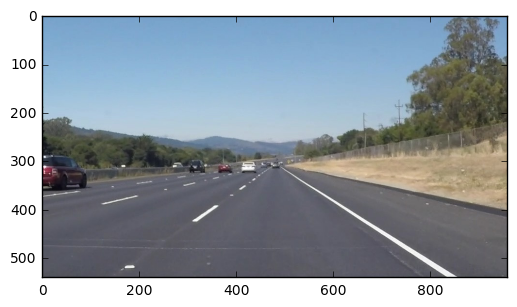

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_vertices(img, points, color=[255,0,0], thickness=2):
    """Debugging help function to draw the region polygon"""
    #print(points)
    cv2.line(img, points[0], points[1], color, thickness)
    cv2.line(img, points[1], points[2], color, thickness)
    cv2.line(img, points[2], points[3], color, thickness)

def extrapolate_to_y(x1,y1,x2,y2 ,Y2, maxY):
    """Takes two points and extrapolates the line between them to a given Y coordinate"""
    
    #If the line is vertical, X2 is the same as X1
    if(x2-x1 == 0):
        return (x1,Y2)
    
    #Get slope from given line
    m = ( (maxY-y2)-(maxY-y1) ) / (x2-x1)
    #print('Extrapolation Slope:',(maxY-y2),(maxY-y1),x2,x1)
    
    #Calculate X2 for given Y2
    X2 = int( ( ((maxY-Y2)-(maxY-y1))/m ) + x1 )
    #print('Extrapolation X2:',((maxY-Y2)-(maxY-y1)),m,x1)
    
    return (X2,Y2)

def get_merged_lines(lines, side, maxY):
    """Takes a set of lines and returnes the averaged extrapolated line for them"""
    X1 = 0
    Y1 = 0
    Y2 = 0
    X2 = 0
    x1Avg = 0
    y1Avg = 0
    x2Avg = 0
    y2Avg = 0
    
    #Loop all lines finding extreme points and positions average
    for x1,y1,x2,y2 in lines:
        x1Avg = x1Avg + x1
        y1Avg = y1Avg + y1
        x2Avg = x2Avg + x2
        y2Avg = y2Avg + y2
        if(X1 == 0 or x1 < X1):
            X1 = x1
            Y1 = y1
        if(side == 'left' and (Y2 == 0 or y2 < Y2)):
            X2 = x2
            Y2 = y2
        if(side == 'right' and (Y2 == 0 or y2 > Y2)):
            X2 = x2
            Y2 = y2
    x1Avg = int(x1Avg/len(lines))
    y1Avg = int(y1Avg/len(lines))
    x2Avg = int(x2Avg/len(lines))
    y2Avg = int(y2Avg/len(lines))    
    
    #Define direction of the extrapolation depending which lane line we are dealing with
    if(side == 'left'):
        projectionPoint1 = maxY
        projectionPoint2 = Y2

    if(side == 'right'):
        projectionPoint1 = Y1
        projectionPoint2 = maxY
    
    #Extrapolate the line accordingly
    ex1, ey1 = extrapolate_to_y(x1Avg,y1Avg,x2Avg,y2Avg, projectionPoint1, maxY)
    ex2, ey2 = extrapolate_to_y(x1Avg,y1Avg,x2Avg,y2Avg, projectionPoint2, maxY)
    
    return (ex1,ey1,ex2,ey2)

def draw_merged_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Takes an image and the lines detected and draws the lane markup """
    leftLines = []
    rightLines = []
    middlePoint = img.shape[1]/2
    middleWindow = 35
    #print('Finding left and right lines:', img.shape)
    #print(len(lines))
    
    #Loop all lines, classifing them to left or right lane lines
    #The determined side is defined by their slope and their position in the 
    #horizonal space
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            if(x2-x1 != 0):
                m = ( (img.shape[0]-y2)-(img.shape[0]-y1) ) / (x2-x1)
                if(m >= 0.5 and x1 < (middlePoint-middleWindow) and x2 <(middlePoint-middleWindow)):
                    #print('Left Slope:',(x1,y1,x2,y2), '[', (img.shape[0]-y2), '-',(img.shape[0]-y1),'/',x2-x1,' ] = ',m)
                    leftLines.append((x1,y1,x2,y2))
                if(m <= -0.5 and x1 > (middlePoint+middleWindow) and x2 > (middlePoint+middleWindow)):
                    #print('right Slope:',(x1,y1,x2,y2), '[', (img.shape[0]-y2), '-',(img.shape[0]-y1),'/',x2-x1,' ] = ',m)
                    rightLines.append((x1,y1,x2,y2))
    #print('Found left lines', len(leftLines))
    #print(leftLines)
    #print('Found right lines', len(rightLines))
    #print(rightLines)

    #Once classified, merge them into one (average) and draw them on the image
    if(len(leftLines) > 0):
        x1,y1,x2,y2 = get_merged_lines(leftLines, 'left', img.shape[0])
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    if(len(rightLines) > 0):
        x1,y1,x2,y2 = get_merged_lines(rightLines, 'right', img.shape[0])
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draws the given lines on the reference image """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def get_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """Finds the hough lines in an image """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def draw_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, merged=False):
    """Returns an image with hough lines drawn."""
    lines = get_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if(merged):
        draw_merged_lines(line_img, lines, thickness=16)
    else:
        draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


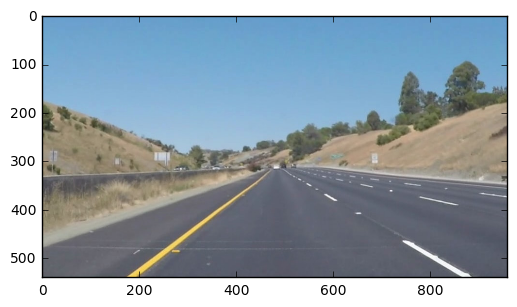

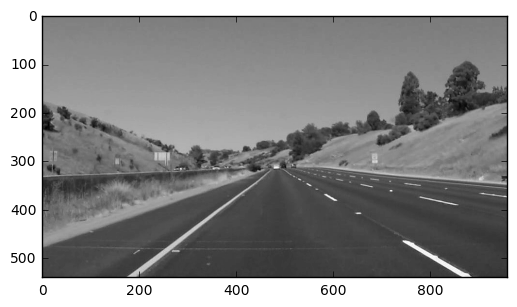

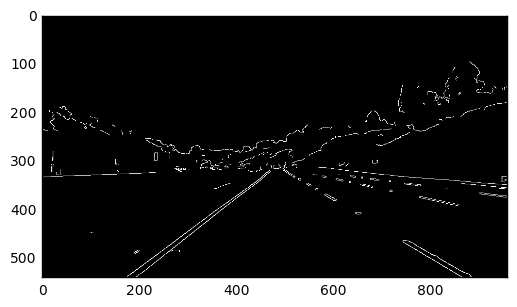

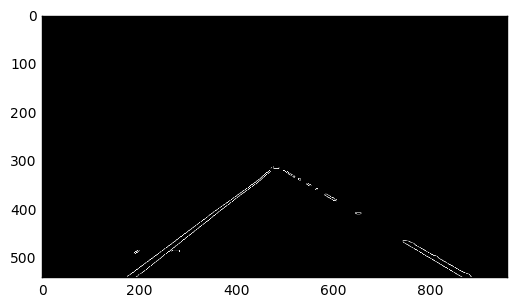

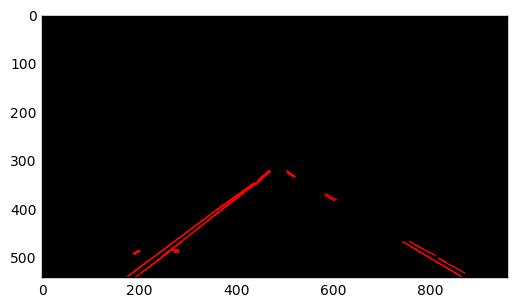

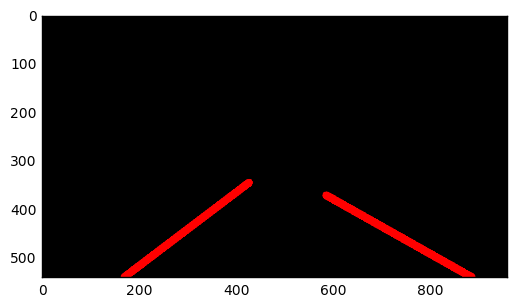

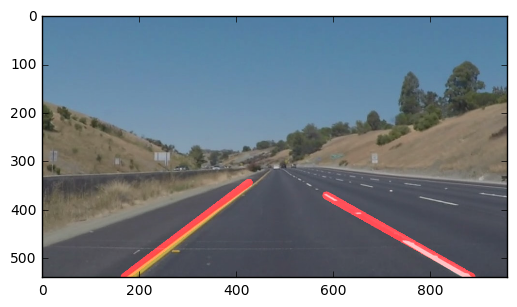

In [6]:
### IMAGE PROCESSING PIPELINE ####

### 1 Reading the image
#image = mpimg.imread('test_images/solidWhiteRight.jpg')    #1
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')    #2
#image = mpimg.imread('test_images/solidYellowLeft.jpg')    #3
#image = mpimg.imread('test_images/solidYellowCurve.jpg')   #4
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')  #5
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg') #6
image_shape = image.shape
print('This image is:', type(image), 'with dimesions:', image_shape) 
plt.figure()
plt.imshow(image)

### 2 Get a grayscale representation 
image_gray = grayscale(image)
plt.figure()
plt.imshow(image_gray, cmap='gray')

### 3 Apply canny transform to detect edges
image_edges = canny(image_gray, 150, 220) 
plt.figure()
plt.imshow(image_edges, cmap='Greys_r')

### 4 Get the region of interest
points = [(0,image_shape[0]),(int(image_shape[1]/2), int(image_shape[0]/2)+40), (int(image_shape[1]/2), int(image_shape[0]/2)+40), (image_shape[1],image_shape[0])]
#Draw the vertices of the region of interest, for debugging
    #draw_vertices(image_edges, points)
    #plt.figure()
    #plt.imshow(image_edges, cmap='Greys_r')
poly_vertices = np.array([points], dtype=np.int32)
image_region = region_of_interest(image_edges, poly_vertices)
plt.figure()
plt.imshow(image_region, cmap='Greys_r')

### 5 Draw the hough lines 
image_lines = draw_hough_lines(image_region, 2, np.pi/180, 20, 10, 3)
plt.figure()
plt.imshow(image_lines)

### 6 Draw the merged lines
image_merged_lines = draw_hough_lines(image_region, 2, np.pi/180, 20, 10, 3, merged=True)
plt.figure()
plt.imshow(image_merged_lines)

### 7 Combine the merged lines on top of the original image
image_markup = weighted_img(image_merged_lines, image)
plt.figure()
plt.imshow(image_markup)



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    '''Process each individual image and return that image with lane markup'''
    image_shape = image.shape
    
    #Get grayscale representation
    image_gray = grayscale(image)
    
    #Apply canny transform to detect edges
    image_edges = canny(image_gray, 50, 100) 
    
    #Draw the region of interest alone
    points = [(0,image_shape[0]),(int(image_shape[1]/2), int(image_shape[0]/2)+40), (int(image_shape[1]/2), int(image_shape[0]/2)+40), (image_shape[1],image_shape[0])]
    poly_vertices = np.array([points], dtype=np.int32)
    image_region = region_of_interest(image_edges, poly_vertices)
    
    # Draw the merged lines
    image_merged_lines = draw_hough_lines(image_region, 2, np.pi/180, 20, 10, 3, merged=True)
    
    #Draw Markup
    image_markup = weighted_img(image_merged_lines, image)

    return image_markup

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 32.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.54 s, sys: 208 ms, total: 2.75 s
Wall time: 6.41 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:20<00:00, 35.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.73 s, sys: 780 ms, total: 10.5 s
Wall time: 21.9 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### About this implementation

This final implementation is the result of a continous iteration process. Initially I was using a canny filter that was pretty agressive in finding very clear borders. I was also simply finding the lowest and highest points on each lane side as reference to draw a single line. This was making the lines jump quite a bit left and right. And in particular, while testing with the challenge video, the lines were all over the place, and crossing each other at the upper ends a lot.

After that I improved it by actually doing the positional average of all the lines found on each side. This made the line to be more stable and not jump left and right so much. 

I also changed the logic that classifies them as "left" or "right" by increasing the slope threshold (ignoring more horizonal lines). I also decided to classify them by their relative location to the image (some elements with the "correct" slope were detected in the wrong side of the image). For this I defined a window in the middle of the image, and considered only lines that were fully within each side of the image (outside of the middle window). This helped with the situation where lane markers were crossing each other. Specially in curves.

Finally in the challenge video there is a segment where the road has a very bright colour. This made the detection algorithm to actually loose sight of the left lane completely for that time. To improve this I lowered the threshold in the canny border detection. This made the algorithm to pick up some other unwanted elements on the road, but the averaging approach kept the lines in what I think is a reasonable compromise. Now the left line is detected even in that bright area of the road. 

As I was working on that issue with the bright area on the road, it made me think that a possible way to improve the robustness of the algorithm would be to have a loop in the line detection part, where if the detection renders an empty set of lines, then we try again with some modified version of the parameters (i.e. lower threshold for canny detection). We can repeat this once or twice before giving up and assumming there are no lane lines in sight. This of course would have to be balanced with the performance of doing these detections in real time. 




## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:16<00:00, 15.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 9.81 s, sys: 901 ms, total: 10.7 s
Wall time: 18.2 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))